In [284]:
import torch
import torch.nn as nn
from jinja2.compiler import F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [285]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=ToTensor()
)

In [286]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [287]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv0 = nn.Conv2d(1,5,kernel_size=5,stride=1) #  24 * 24 * 10
        self.conv1 = nn.Conv2d(5,5,kernel_size=5,stride=1) # 20 * 20 * 10
        self.poolLayer = nn.MaxPool2d(kernel_size=2,stride=2) # 10 * 10 * 10
        self.conv2 = nn.Conv2d(5,5,kernel_size=5,stride=1) # 6 * 6 * 10 -> 3 * 3 * 10
        
        self.layer0 = nn.Linear(3 * 3 * 5, 150)
        self.layer1 = nn.Linear(150, 10, bias=True)
        
    def forward(self, x):


        x = nn.functional.relu(self.conv0(x))
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.poolLayer(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.poolLayer(x))

        x = x.view(-1, 3 *3 * 5)
        
        x = nn.functional.relu(self.layer0(x))
        x = nn.functional.relu(self.layer1(x))

        return x

In [288]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [289]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [290]:
model = model = Model().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 24, 24]             130
            Conv2d-2            [-1, 5, 20, 20]             630
         MaxPool2d-3            [-1, 5, 10, 10]               0
            Conv2d-4              [-1, 5, 6, 6]             630
         MaxPool2d-5              [-1, 5, 3, 3]               0
            Linear-6                  [-1, 150]           6,900
            Linear-7                   [-1, 10]           1,510
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.04
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [291]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid over-fitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

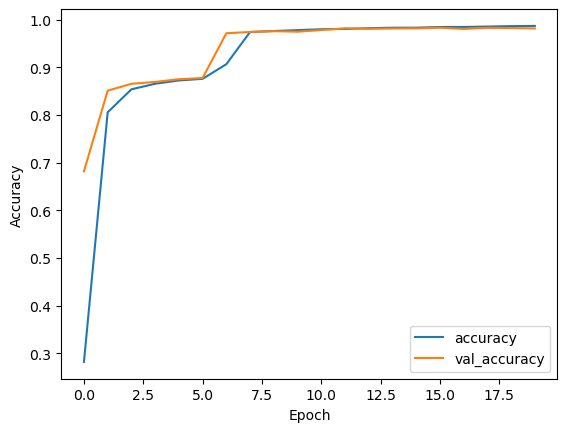

In [292]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [293]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.9814000129699707, 0.9866166710853577)